# THz Pulse Model


### Part 1: FFT and Waveform Generation

#### Potential Bug:
Not all values of num_pts for the t parameter in the function fourier work. There is something incoherent with the way the time and frequency domains are calculated.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.integrate as integrate
import scipy.special as special
from scipy.optimize import curve_fit
import math
import time
sns.set()
%matplotlib inline

In [4]:
## Define waveform ##
def Efield(t, E0 = 1, w=2*np.pi*0.8, s = 0.4 , phi = 0 ):
    return E0*np.sin(w*t+phi)*np.exp(-0.5*(t)**2/s**2) # sin*gaussian

In [5]:
## Define FFT ##
def fourier(t, func):
    freq = np.arange(-1/(abs(t[0])-abs(t[1]))/2, 1/(abs(t[0])-abs(t[1]))/2 , 1/(t[-1]-t[0]))
    ft = np.fft.fft(func)
    ftshift = np.fft.fftshift(ft)
    return np.array([freq, ft, ftshift])

Integral: 5.551115123125783e-17


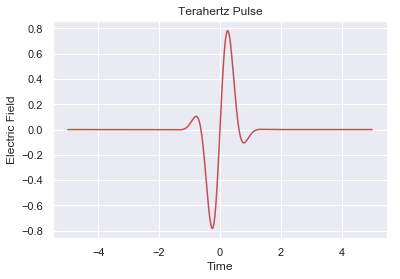

In [6]:
## Sample ##
t = np.linspace(-5,5,1000)
plt.plot(t, Efield(t, w = 0.8*2*np.pi, s = 0.4), 'r')
plt.title("Terahertz Pulse")
plt.xlabel("Time")
plt.ylabel("Electric Field")
print("Integral:", np.trapz(Efield(t, w = 0.8*2*np.pi, s = 0.4, phi = 0),t))

Integral: 0.13283504548731645


'Problem: Non-Zero Integral'

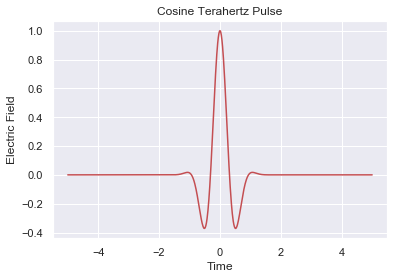

In [7]:
## Cosine Times Gaussian Example ##
t = np.linspace(-5,5,1000)
plt.plot(t, Efield(t, w = 0.8*2*np.pi, s = 0.4, phi = np.pi/2), 'r')
plt.title("Cosine Terahertz Pulse")
plt.xlabel("Time")
plt.ylabel("Electric Field")
print("Integral:", np.trapz(Efield(t, w = 0.8*2*np.pi, s = 0.4, phi = np.pi/2),t))
"""Problem: Non-Zero Integral"""

/Users/Nathan/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Electric Field')

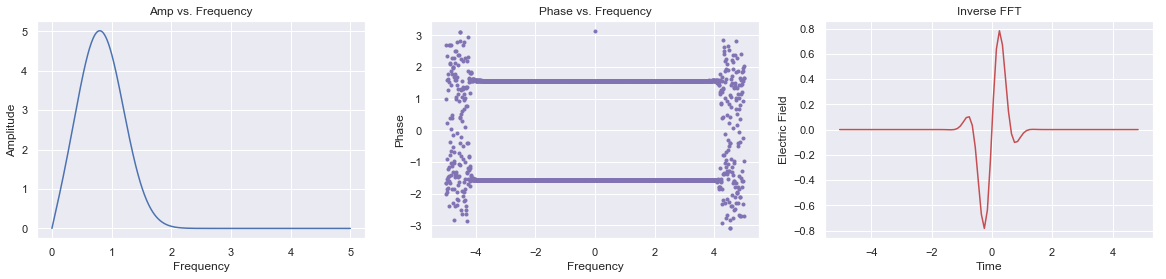

In [8]:
## Transform Sample ##

num_pts = 2001 # calculating number of points so time and freq have same length, might still need to be resolved
t = np.arange(-100,100,200/num_pts)
ft = fourier(t , func = Efield(t, w = 2*np.pi*0.8, s = 0.4))

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize= (20,4)) # make subplots
ax1.plot(ft[0][1000:-1], np.abs(ft[2])[1000:-1])  #plot only 0 to 5
#ax1.plot(ft[0], np.abs(ft[1]))
ax1.set_title("Amp vs. Frequency")
ax1.set_xlabel("Frequency")
ax1.set_ylabel("Amplitude")

ax2.plot(ft[0], np.angle(ft[2]), 'm.')
#ax2.plot(ft[0][700:1300], np.angle(ft[1])[700:1300], 'm.')
ax2.set_title("Phase vs. Frequency")
ax2.set_xlabel("Frequency")
ax2.set_ylabel("Phase")

pulse = np.fft.ifft(ft[1])
ax3.plot(t[950:1050], pulse[950:1050], 'r') # Zoomed in
#ax3.plot(t, pulse, 'r')                    # not zoomed in
ax3.set_title("Inverse FFT")
ax3.set_xlabel("Time")
ax3.set_ylabel("Electric Field")


Integral of InvFFT: (-3.990527390531434e-06-7.203012032191694e-23j)


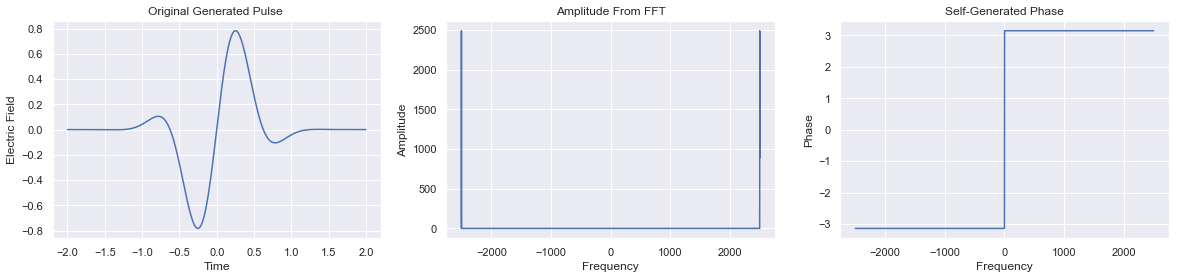

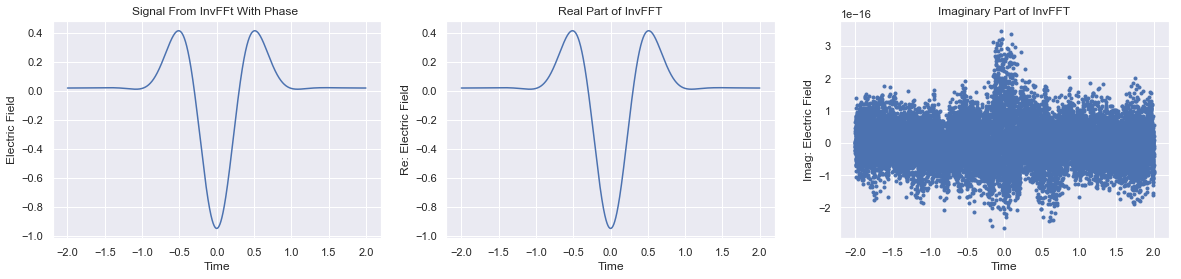

In [9]:
## Generating a pulse with a different phase ##

t = np.linspace(-2,2,20020)
ft = fourier(t , func = Efield(t, w = 2*np.pi*0.8, s = 0.4))
amp = np.abs(ft[1])

phi = np.zeros(len(ft[0]))  # make array filled with zeros

for i in range(-10010,10010):      # fill array with values
    if i >= 0:
        phi[i] = -np.pi
    if i < 0:
        phi[i] = np.pi

        
pulse = np.fft.ifft(amp*np.exp(1j*phi)) # invFFT signal with new phase
signal = []  # make empty list

for i in range(10010,20020):  # invFFT gives signal shifted, but inFFTshift won't work; this is a manual shift
    signal.append(pulse[i])
    
for i in range(10010):
    signal.append(pulse[i])
    
## Plots ##

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,4))
fig, (ax4, ax5, ax6) = plt.subplots(1,3, figsize = (20,4))

ax1.plot(t, Efield(t, w = 2*np.pi*0.8, s = 0.4))
ax1.set_title("Original Generated Pulse ")
ax1.set_xlabel("Time")
ax1.set_ylabel("Electric Field")

ax2.plot(ft[0],amp)
ax2.set_title("Amplitude From FFT")
ax2.set_xlabel("Frequency")
ax2.set_ylabel("Amplitude")

ax3.plot(ft[0],phi)
ax3.set_title("Self-Generated Phase")
ax3.set_xlabel("Frequency")
ax3.set_ylabel("Phase")

ax4.plot(t,signal)
ax4.set_title("Signal From InvFFt With Phase ")
ax4.set_xlabel("Time")
ax4.set_ylabel("Electric Field")

ax5.plot(t,np.real(signal))
ax5.set_title("Real Part of InvFFT")
ax5.set_xlabel("Time")
ax5.set_ylabel("Re: Electric Field")

ax6.plot(t,np.imag(signal), '.')
ax6.set_title("Imaginary Part of InvFFT")
ax6.set_xlabel("Time")
ax6.set_ylabel("Imag: Electric Field")


print("Integral of InvFFT:",integrate.simps(y = signal, x = t)) 

#### Note:

Step function must be symmetric about zero for the imaginary part to be zero.

### Part 2: Current Generation

In [10]:
## Generate current class ##
## Generate current class ##

class current():
    
    # initialize current types and variables # 
    
    def __init__(self, height1=1, squeeze1=1, pos1=0, height2=1, squeeze2=1, pos2=0, shift=0, 
                 phi_t=8.01088e-19, phi_s=8.01088e-19, z = 0.5e-9, A=1e-9, 
                 erf=False, ohm=False, cubic=False, exp=False, double_erf=False, step=False, Simmons=False):
        self.height1 = height1
        self.squeeze1 = squeeze1
        self.pos1 = pos1
        self.height2 = height2
        self.squeeze2 = squeeze2
        self.pos2 = pos2
        self.shift = shift
        self.phi_t = phi_t
        self.phi_s = phi_s
        self.z = z
        self.A = A
        
        
        self.erf = erf
        self.ohm = ohm
        self.cubic = cubic
        self.exp = exp
        self.double_erf = double_erf
        self.step = step
        self.Simmons = Simmons
        
    # Call calculate to generate I[V(t)] #  
        
    def calculate(self, V):
        if self.erf == True:
            calculate = self.height1*special.erf((V-self.pos1)*self.squeeze1) + self.shift
        if self.double_erf == True:
            calculate = self.height1*special.erf((V-self.pos1)*self.squeeze1) + self.height2*special.erf((V - self.pos2)*self.squeeze2) + self.shift
        if self.cubic == True:
            calculate = self.height1*(V*self.squeeze1 - self.pos1)**3 + self.height2*(V*self.squeeze2 - self.pos2) + self.shift
        if self.step == True:
            calculate = self.height1 * (V > self.pos1)
        if self.ohm == True:
            calculate = (V - self.pos1)/self.height1 + self.shift
        if self.exp == True:
            calculate = self.height1*np.exp(-(V*self.squeeze1 - self.pos1)) + self.shift
        if self.Simmons == True:

            I = []
            
            for i in range(0,len(V)):
  
                if V[i]*1.60217662e-19 > -self.phi_t and V[i]*1.60217662e-19 < self.phi_s:
                    phi_bar = (self.phi_t+self.phi_s-abs(V[i])*1.60217662e-19)/2
                    delta = self.z
 
                if V[i]*1.60217662e-19 >= self.phi_s:
                    phi_bar = self.phi_t/2
                    delta = self.z*self.phi_t/(self.phi_t-self.phi_s+abs(V[i])*1.60217662e-19)
                    beta = 23/24

                if V[i]*1.60217662e-19 <= -self.phi_t:
                    phi_bar = self.phi_s/2
                    delta = self.z*self.phi_s/(self.phi_s-self.phi_t+abs(V[i])*1.60217662e-19)
                    beta = 23/24

                if V[i]*1.60217662e-19 >= 0 and V[i]*1.60217662e-19 < self.phi_s:
                    beta = 1-1/24*((abs(V[i])*1.60217662e-19-self.phi_s+self.phi_t)/(abs(V[i])*1.60217662e-19-self.phi_s-self.phi_t))**2
                
                if V[i]*1.60217662e-19 > -self.phi_t and V[i]*1.60217662e-19 < 0:
                    beta = 1-1/24*((abs(V[i])*1.60217662e-19+self.phi_s-self.phi_t)/(abs(V[i])*1.60217662e-19-self.phi_s-self.phi_t))**2

                if V[i] >= 0:
                    I.append(1.60217662e-19*self.A/(1.0545718e-34*(2*np.pi*beta*delta)**2)*(
                        phi_bar*np.exp(-2*beta*delta*np.sqrt(9.10938356e-31*2*phi_bar)/1.0545718e-34)
                        -(phi_bar+abs(V[i])*1.60217662e-19)*np.exp(-2*beta*delta*np.sqrt(9.10938356e-31*2)
                                                           *np.sqrt(phi_bar+abs(V[i])*1.60217662e-19)/1.0545718e-34)))

                if V[i] < 0: 
                    I.append(-1.60217662e-19*self.A/(1.0545718e-34*(2*np.pi*beta*delta)**2)*(
                        phi_bar*np.exp(-2*beta*delta*np.sqrt(9.10938356e-31*2*phi_bar)/1.0545718e-34)
                        -(phi_bar+abs(V[i])*1.60217662e-19)*np.exp(-2*beta*delta*np.sqrt(9.10938356e-31*2)
                                                           *np.sqrt(phi_bar+abs(V[i])*1.60217662e-19)/1.0545718e-34)))
       
            calculate = np.asarray(I)
   
        else:
            pass
        
        return calculate

(-3.988956817814772e-05-3.7836930172556885e-21j) (0.42133814098756767+3.635727258821721e-18j)


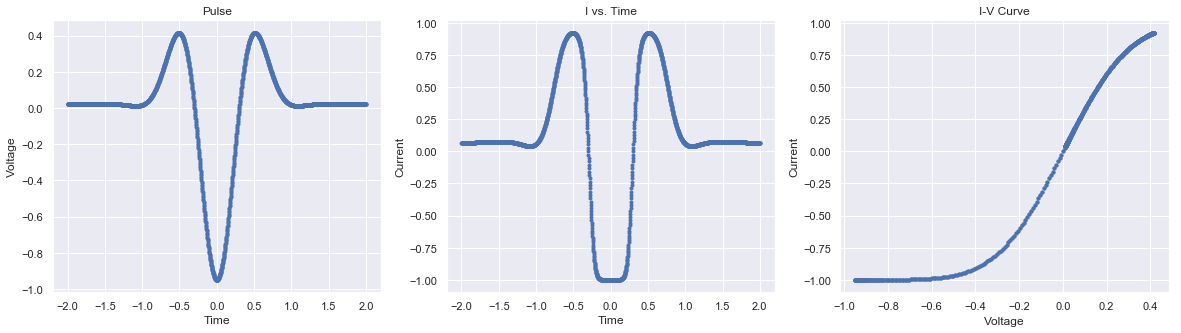

In [11]:
## Test out I calculation ##

t = np.linspace(-2,2,2002)
ft = fourier(t , func = Efield(t, w = 2*np.pi*0.8, s = 0.4))
amp = np.abs(ft[1])

phi = np.zeros(len(ft[0]))  # make array filled with zeros

for i in range(-1000,1001):      # fill array with values
    if i >= 0:
        phi[i] = -np.pi
    else:
        phi[i] = np.pi


pulse = np.fft.ifft(amp*np.exp(1j*phi)) # invFFT signal with new phase
signal = []  # make empty list

for i in range(1001,2002):  # invFFT gives signal shifted, but inFFTshift won't work; this is a manual shift
    signal.append(pulse[i])
    
for i in range(1001):
    signal.append(pulse[i])

signal = np.asarray(signal)

I = current(height1 = 1, pos1 = 0, squeeze1 = 3, erf = True)


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,5))

ax1.plot(t, signal, '.')
ax1.set_title("Pulse")
ax1.set_xlabel("Time")
ax1.set_ylabel("Voltage")

ax2.plot(t, I.calculate(signal), '.')
ax2.set_title("I vs. Time")
ax2.set_ylabel("Current")
ax2.set_xlabel("Time")

ax3.plot(signal, I.calculate(signal), '.')
ax3.set_title("I-V Curve")
ax3.set_ylabel("Current")
ax3.set_xlabel("Voltage")



print(integrate.simps(y=signal, x=t), integrate.simps(y=I.calculate(signal), x=t))

###  Part 3: Phase Sweeping

In [12]:
## Define Phase Sweep ##

def phase_sweep(phi_range, sweep_pts, freq, fft, current, t):
    
    phi_0 = -phi_range/2
    amp = np.abs(fft)
    phase = []
    I = []
    I_integral = []
    sig_array = []
    sig_integral = []
    problem = []
    
    
    for i in range(0,sweep_pts): # *****Check to see if this will mess up length stuff

        phi = np.zeros(len(freq))       # re-initialize phi matrix
        

        for j in range(0, len(freq)):      # fill array with values
            if j >= int(len(freq)/2):
                phi[j] = phi_0
            else:
                phi[j] = -phi_0
        
        pulse = np.fft.ifft(amp*np.exp(1j*phi)) # get pulse back with new phase
        signal = []
         
        for k in range(int(len(freq)/2),int(len(freq))):  # manually shift ifft
            signal.append(pulse[k])

        for l in range(int(len(freq)/2)):
            signal.append(pulse[l])
        
        

        phase.append(phi_0)             # store phase values
        signal = np.asarray(signal) 
        I_integral.append(integrate.simps(x=t, y=current.calculate(signal))) # compute I(t) integral
        I.append(current.calculate(signal))
        sig_array.append(signal)
        sig_integral.append(integrate.simps(x=t, y=signal))
        phi_0 += phi_range/sweep_pts     # compute new phi for next loop
        
            
        
        #plt.plot(t, signal)            # Plot envelope of signals

    phase = np.asarray(phase)
    I_integral = np.asarray(I_integral)
    I = np.asarray(I)
    sig_array = np.asarray(sig_array)
    
    return [phase, I_integral, sig_array, I, sig_integral]


(0.9487075731539114-7.094785179831255e-17j)


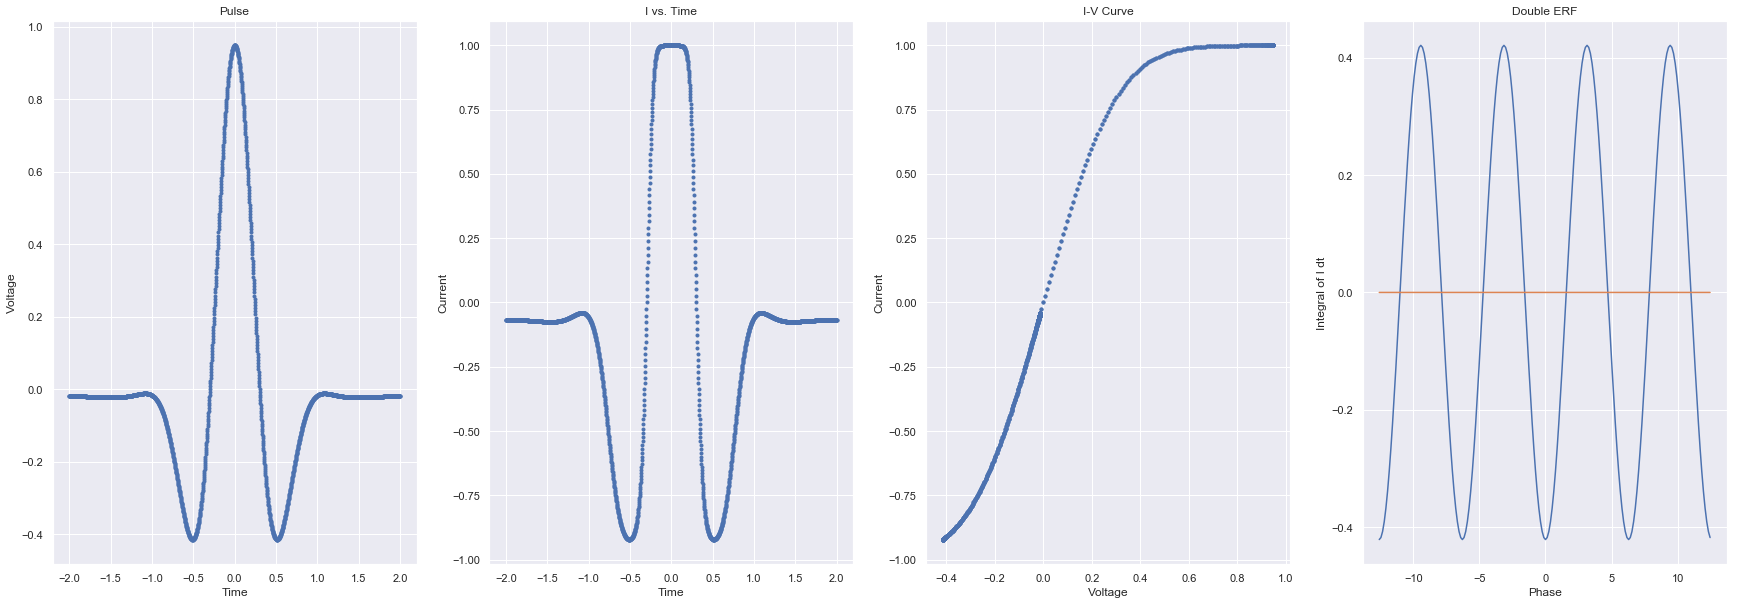

In [13]:
## Test out phase_sweep calculation ##

t = np.linspace(-2,2,2003)
ft = fourier(t , func = Efield(t,w = 2*np.pi*0.8, s = 0.4, E0=1))
I = current(height1 = 1, pos1 = 0, squeeze1 = 3, erf = True)
sweep = phase_sweep(phi_range = 8*np.pi, sweep_pts = 200 , freq = ft[0], fft = ft[1], current = I , t = t) 

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (30,10))


ax1.plot(t, sweep[2][0], '.')
ax1.set_title("Pulse")
ax1.set_xlabel("Time")
ax1.set_ylabel("Voltage")

ax2.plot(t, I.calculate(sweep[2][0]), '.')
ax2.set_title("I vs. Time")
ax2.set_ylabel("Current")
ax2.set_xlabel("Time")

ax3.plot(sweep[2][0], I.calculate(sweep[2][0]), '.')
ax3.set_title("I-V Curve")
ax3.set_ylabel("Current")
ax3.set_xlabel("Voltage")

ax4.plot(sweep[0], sweep[1])
ax4.plot(sweep[0], sweep[4])
ax4.set_title("Double ERF")
ax4.set_xlabel("Phase")
ax4.set_ylabel("Integral of I dt")
print(max(sweep[2][0]))

#### Finding a "Threshold"

Text(0, 0.5, 'I')

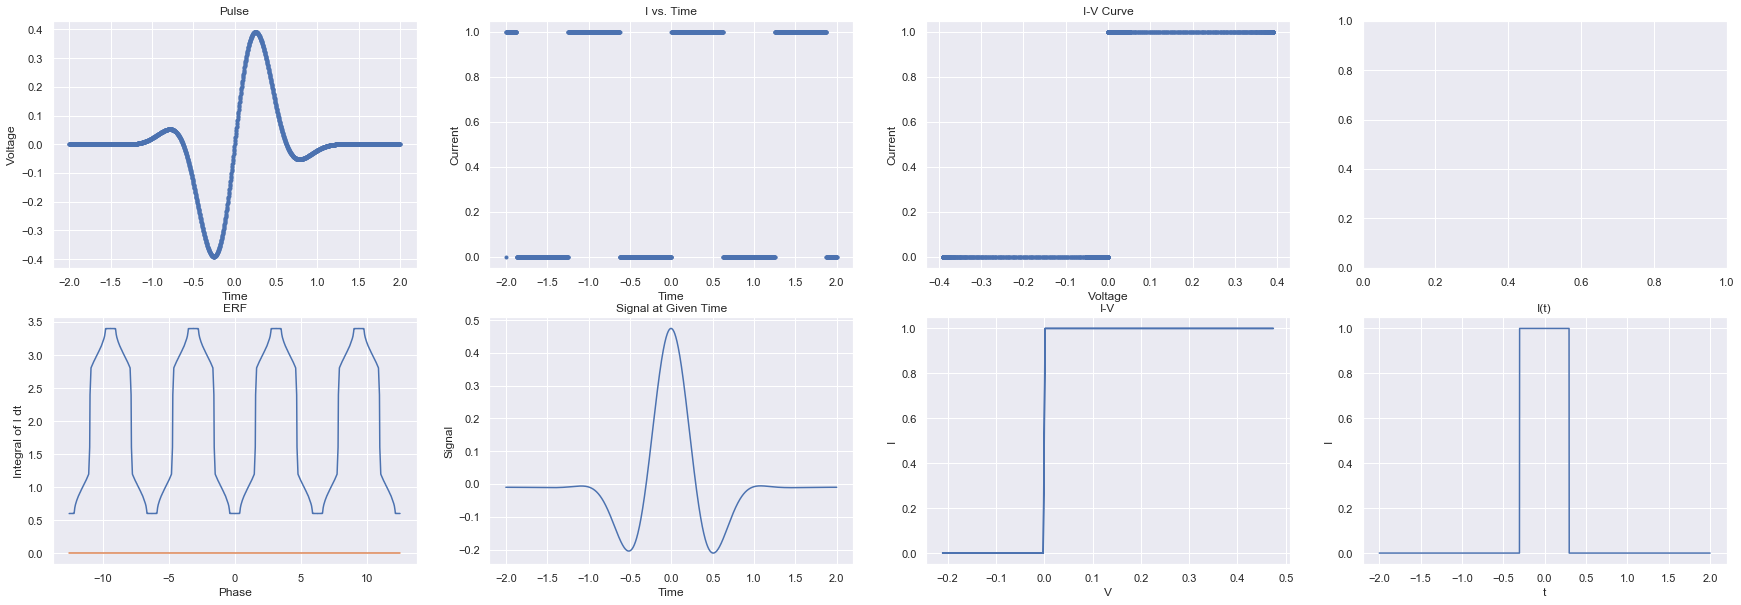

In [14]:
## finding threshold with step function ##

t = np.linspace(-2,2,2002)
ft = fourier(t , func = Efield(t, E0=0.5, w = 2*np.pi*0.8, s = 0.4))
amp = np.abs(ft[1])

phi = np.zeros(len(ft[0]))  # make array filled with zeros

for i in range(-1000,1001):      # fill array with values
    if i >= 0:
        phi[i] = -np.pi/2
    else:
        phi[i] = np.pi/2


pulse = np.fft.ifft(amp*np.exp(1j*phi)) # invFFT signal with new phase
signal = []  # make empty list

for i in range(1001,2002):  # invFFT gives signal shifted, but invFFTshift won't work; this is a manual shift
    signal.append(pulse[i])
    
for i in range(1001):
    signal.append(pulse[i])

signal = np.asarray(signal)

I = current(height1 = 1, pos1 = 0, squeeze1 = 3, step = True) # create current type

# Plot #
fig, axes = plt.subplots(nrows=2, ncols=4, figsize = (30,10))

axes[0,0].plot(t, signal, '.')
axes[0,0].set_title("Pulse")
axes[0,0].set_xlabel("Time")
axes[0,0].set_ylabel("Voltage")

axes[0,1].plot(t, I.calculate(signal), '.')
axes[0,1].set_title("I vs. Time")
axes[0,1].set_ylabel("Current")
axes[0,1].set_xlabel("Time")

axes[0,2].plot(signal, I.calculate(signal), '.')
axes[0,2].set_title("I-V Curve")
axes[0,2].set_ylabel("Current")
axes[0,2].set_xlabel("Voltage")


sweep = phase_sweep(phi_range = 8*np.pi, sweep_pts = 1000 , freq = ft[0], fft = ft[1], current = I , t = t) 

axes[1,0].plot(sweep[0], sweep[1])
axes[1,0].plot(sweep[0], sweep[4])
axes[1,0].set_title("ERF")
axes[1,0].set_xlabel("Phase")
axes[1,0].set_ylabel("Integral of I dt")

axes[1,1].plot(t, sweep[2][-1])
axes[1,1].set_title("Signal at Given Time")
axes[1,1].set_xlabel("Time")
axes[1,1].set_ylabel("Signal")

axes[1,2].plot(sweep[2][-1], sweep[3][-1])
axes[1,2].set_title("I-V")
axes[1,2].set_xlabel("V")
axes[1,2].set_ylabel("I")

axes[1,3].plot(t, sweep[3][-1])
axes[1,3].set_title("I(t)")
axes[1,3].set_xlabel("t")
axes[1,3].set_ylabel("I")

### Part 4: Charge Rectification

In [15]:
def amplitude_sweep(t, current, num_pts, maxE0, phi_range, phase_pts, minE0=0 ):
 
    E0 = np.linspace(minE0,maxE0,num_pts) # create array of sweep parameters
    I_integral = []  # make empty list
    ft = fourier(t, func = Efield(t,w = 2*np.pi*0.8, s = 0.4, E0=1)) # FFT
    sweep = phase_sweep(phi_range = phi_range, sweep_pts = phase_pts , freq = ft[0], fft = ft[1], current = I , t = t) # Sweep phase and create signal

    for i in range(0,num_pts):
        I_integral.append(integrate.simps(x=t, y=current.calculate(E0[i]*sweep[2]))) # calculate the integral and store it into the empty list
    
    
    I_integral = np.asarray(I_integral) #turn list into numpy array
    return np.array([sweep, E0, I_integral])

/Users/Nathan/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:2788: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


Text(0, 0.5, 'Amplitude')

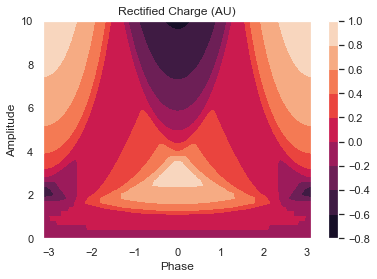

In [16]:
# Generate Simulated Data #

I = current(height1 = 1, pos1 = 1, pos2 = -1.5, shift = 0, squeeze1 = 10,squeeze2 = 10, double_erf = True) # call current with desired attributes
t = np.linspace(-2,2,2002) 
amp_sweep = amplitude_sweep(t=t,current=I, phi_range = 2*np.pi, phase_pts = 200, maxE0 = 10, num_pts = 50) # call function

# Plot #
fig, ax1 = plt.subplots()
cep = ax1.contourf(amp_sweep[0][0], amp_sweep[1], amp_sweep[2]) # contour (color) map 
fig.colorbar(cep) # apply colorbar
ax1.set_title('Rectified Charge (AU)')
ax1.set_xlabel('Phase')
ax1.set_ylabel('Amplitude')